In [26]:

trn, tst = 1, 23
n_segments= 500
compactness= 15


# Segmentation and Training Image

<class 'list'> 471 (471, 200)
<class 'list'> 471 (471,)
<class 'list'> 471 (471,)


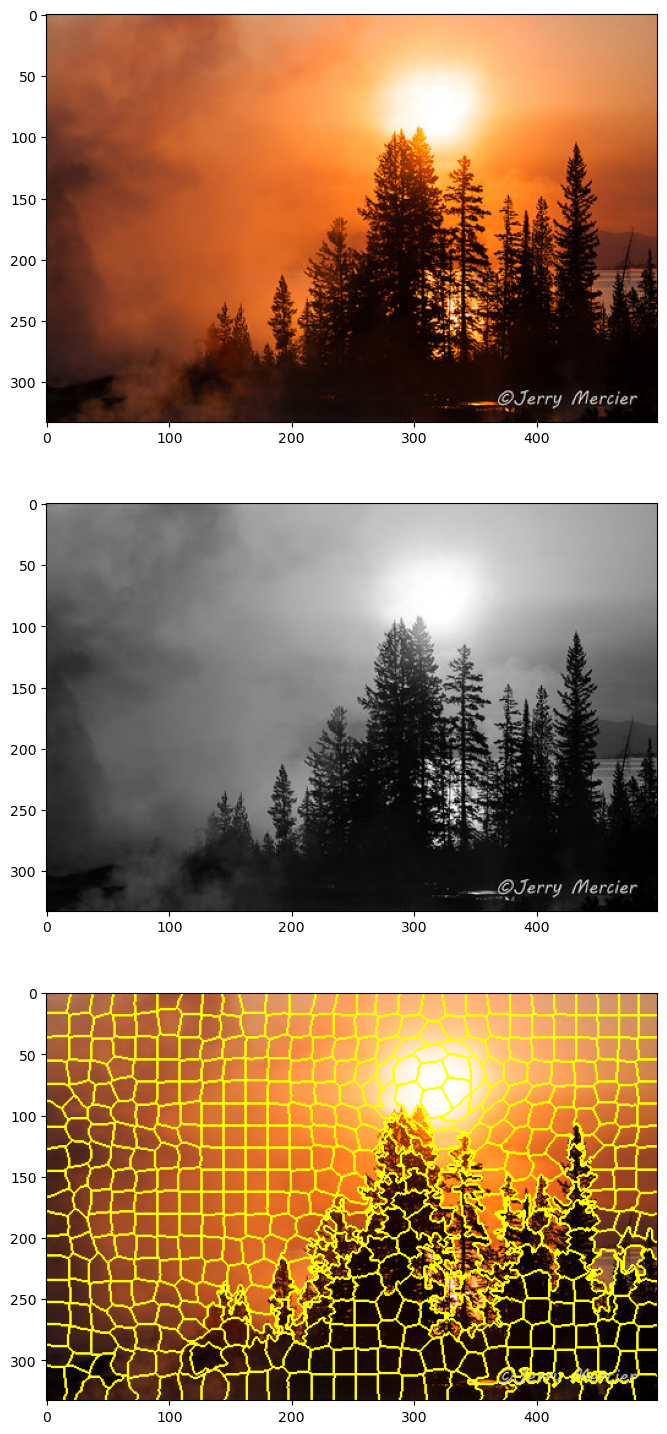

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb



im = cv2.cvtColor(cv2.imread(f"data/{trn}.jpg"),cv2.COLOR_BGR2RGB)
gim = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(14,18))




def generateSubsquareFeatureData(im):
    segments = slic(im, n_segments=n_segments, compactness=compactness, sigma=1)
    #segments = label2rgb(segments, im, kind='avg')
    plt.subplot(3,1,3)
    plt.imshow(mark_boundaries(im, segments))

    square_size = 10
    fv=[]
    U=[]
    V=[]
    
    for label in np.unique(segments):
        mask = label==segments
        centroid = np.array([np.mean(np.nonzero(mask)[0]), np.mean(np.nonzero(mask)[1])]).astype(int)

        if (centroid[0] - square_size // 2 >= 0 and centroid[0] + square_size // 2 < im.shape[0] and
        centroid[1] - square_size // 2 >= 0 and centroid[1] + square_size // 2 < im.shape[1]):
            # Process the segment
            square = im[centroid[0] - square_size // 2:centroid[0] + square_size // 2,
                         centroid[1] - square_size // 2:centroid[1] + square_size // 2]
            yuvsquare = cv2.cvtColor(square,cv2.COLOR_RGB2YUV)
            u = np.mean(yuvsquare[:, :, 1])
            v = np.mean(yuvsquare[:, :, 2])
            fft = np.fft.fft2(yuvsquare[:, :, 0])
            feature_vector = np.concatenate((np.real(fft).flatten(), np.imag(fft).flatten()))
            
            U.append(u)
            V.append(v)
            fv.append(feature_vector)
            #print(len(feature_vector))
            #max_fv_size = max(max_fv_size,len(feature_vector))
            
        else:
            U.append(0)
            V.append(0)
            fv.append(np.zeros(2 * square_size * square_size))
            continue
            
    return fv, U, V
    



fv, U, V = generateSubsquareFeatureData(im)

# fv--> list of arrays(fft of each subsquare float64)
# U--> list of numbers(Uavg of each subsquare float64)
# V--> list of numbers(Vavg of each subsquare float64)

print(type(fv),len(fv),np.array(fv).shape)
print(type(U),len(U),np.array(U).shape)
print(type(V),len(V),np.array(V).shape)

plt.subplot(3,1,1)
plt.imshow(im)

plt.subplot(3,1,2)
plt.imshow(gim,cmap='gray')

['data/1.jpg', 'data/2.jpg', 'data/3.jpg', 'data/4.jpg', 'data/5.jpg', 'data/6.jpg', 'data/7.jpg', 'data/8.jpg', 'data/9.jpg', 'data/10.jpg', 'data/11.jpg']
Processing data/1.jpg
(471, 200)
(471, 200) (471,) (471,)


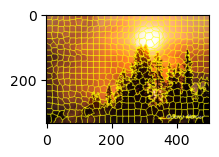

In [28]:
files = [f"data/{i}.jpg" for i in range(1,12)]


print(files)
def resize_and_generate_feature_data(files):
    if type(files) == str:
        return resize_and_generate_feature_data([files])
        
    features, U, V = [], [], []
    Y = []
    for image_path in files:
        print(f"Processing {image_path}")
        img=cv2.imread(image_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        #img = cv2.resize(img, (500,300))  # SET SIZE
        fv, u, v = generateSubsquareFeatureData(img)
        y = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
        features.append(np.array(fv))
        U.append(u)
        V.append(v)
        Y.append(y)
        print(np.array(fv).shape)
    
    U = [np.array(i) for i in U]
    V = [np.array(i) for i in V]
    
    features = np.vstack(features)
    U = np.hstack(U)
    V = np.hstack(V)
    
    print(features.shape, U.shape, V.shape)
    return Y, features, U, V



#For training Multiple files use:

#I_train, I_test = files[:len(files)-3], files[len(files)-3:]
# ----OR-----
#I_train, I_test = train_test_split(files)

i=1
I_train, I_test = [f"data/{trn}.jpg"],[f"data/{tst}.jpg"]


Y_train, X_train, U_train, V_train=resize_and_generate_feature_data(I_train)


# Training

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import joblib
import numpy as np



print(X_train.shape)
print(U_train.shape)
print(V_train.shape)

# Training

C = 40                     #0.125 
SVR_EPSILON = 15   #0.0625  

u_svr = SVR(C=C, epsilon=SVR_EPSILON, kernel='rbf')
v_svr = SVR(C=C, epsilon=SVR_EPSILON, kernel='rbf')

u_svr.fit(X_train, U_train)
v_svr.fit(X_train, V_train)

print("Trained Successfully")

(471, 200)
(471,)
(471,)
Trained Successfully


# Testing model on some grayscale image and evaluating error

Processing: data/23.jpg
MSE (U):  1319.8701600391594
MSE (V):  2254.81491189869


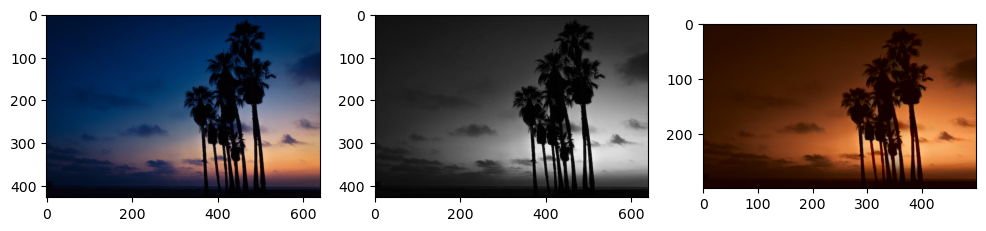

Additional information or processing steps if needed.



In [31]:
from sklearn.metrics import mean_squared_error


def segmentation_features(im):
    segments = slic(im, n_segments=n_segments, compactness=compactness, sigma=1)


    square_size = 10
    fv=[]
    U=[]
    V=[]

    
    for label in np.unique(segments):
        mask = label==segments
        centroid = np.array([np.mean(np.nonzero(mask)[0]), np.mean(np.nonzero(mask)[1])]).astype(int)

        if (centroid[0] - square_size // 2 >= 0 and centroid[0] + square_size // 2 < im.shape[0] and
        centroid[1] - square_size // 2 >= 0 and centroid[1] + square_size // 2 < im.shape[1]):
            square = im[centroid[0] - square_size // 2:centroid[0] + square_size // 2,
                         centroid[1] - square_size // 2:centroid[1] + square_size // 2]
            yuvsquare = cv2.cvtColor(square,cv2.COLOR_RGB2YUV)

            fft = np.fft.fft2(yuvsquare[:, :, 0])
            feature_vector = np.concatenate((np.real(fft).flatten(), np.imag(fft).flatten()))

            fv.append(feature_vector)

            u = np.mean(yuvsquare[:, :, 1])
            v = np.mean(yuvsquare[:, :, 2])

            U.append(u)
            V.append(v)
        else:
            U.append(0)
            V.append(0)
            fv.append(np.zeros(2 * square_size * square_size))
            continue
            
    return segments, fv, U, V

def colorize_image(image_path, u_svr, v_svr, n_segments=500, compactness=20, sigma=1):
    # Read the image
    test_image = cv2.imread(image_path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    test_image = cv2.resize(im, (500,300))
    segments, fv, U, V = segmentation_features(test_image)

    predicted_U = u_svr.predict(fv)
    predicted_V = v_svr.predict(fv)

    yuv_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2YUV)

    print(f"MSE (U): ",mean_squared_error(U, predicted_U))
    print(f"MSE (V): ",mean_squared_error(V, predicted_V))

    count = 0
    for label in np.unique(segments):
        mask = label == segments

        yuv_image[mask, 1] = predicted_U[count]  # U channel
        yuv_image[mask, 2] = predicted_V[count]  # V channel
        count += 1

    colorized_image_rgb = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2RGB)

    return colorized_image_rgb



for image_path in I_test:
    
    print(f"Processing: {image_path}")
    cim = colorize_image(image_path, u_svr, v_svr)

    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    gim = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(im)
    plt.subplot(1, 3, 2)
    plt.imshow(gim, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.imshow(cim)

    plt.show()  


    print("Additional information or processing steps if needed.")
    print()

